In [1]:
#import libraries
import pandas as pd
import numpy as np
import math
from math import sqrt
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model #for plotting  model charts
from sklearn.preprocessing import RobustScaler,StandardScaler
from keras import regularizers
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
import seaborn as sns
from datetime import datetime
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import models,layers,activations,losses,optimizers,metrics
from tensorflow.keras.models import Model

In [2]:
#load data
train_data = pd.read_pickle("EDA_train_mean.pkl")
test_data = pd.read_pickle("EDA_test_mean.pkl")

In [3]:
#separate target variable
y = train_data['windmill_generated_power(kW/h)']
train_data.drop(['windmill_generated_power(kW/h)'], axis=1, inplace = True)

In [4]:
#split dataset 
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22459, 33), (22459,), (5615, 33), (5615,))

In [5]:
#Training model with all features

### RANDOM FOREST USING Standard SCALER

In [6]:
#fit independent variable to the dependent variable
pipeline = Pipeline([
    ('Scaler', StandardScaler()),
    ('regressor', RandomForestRegressor()) # Added to the original code
])
pipeline.fit(X_train,y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('regressor', RandomForestRegressor())])

In [7]:
pipeline.score(X_train,y_train)

0.986404479330519

In [8]:
pipeline.score(X_test,y_test)

0.9084276681009156

In [9]:
#RF Tree Model Evaluation
prediction = pipeline.predict(X_test)

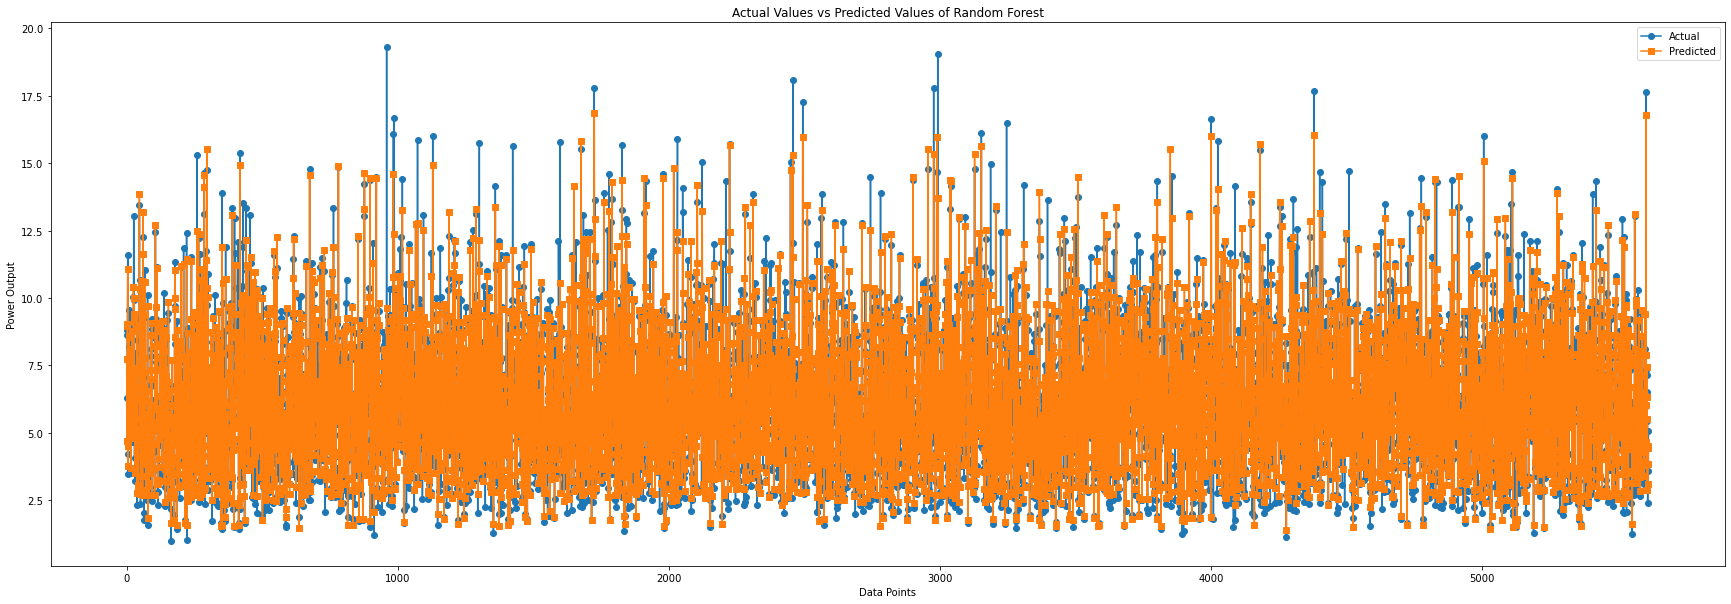

In [10]:
# Sort the actual and predicted values based on the data points
sorted_indices = range(len(y_test))
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = prediction[sorted_indices]

# Line plot with markers for actual and predicted values
plt.rcParams['figure.figsize'] = [30, 10]
plt.plot(sorted_indices, y_test_sorted, marker='o', label='Actual')
plt.plot(sorted_indices, y_pred_sorted, marker='s', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Power Output')
plt.title('Actual Values vs Predicted Values of Random Forest')
plt.legend()
plt.show()

### Extra Trees Regressors

In [11]:
# Feature selection by ExtraTreesRegressor(model based). 
# ExtraTreesRegressor helps us find the features which are most important.
reg= ExtraTreesRegressor()
reg.fit(X_train,y_train)

ExtraTreesRegressor()

In [12]:
#print each feature importance
reg_importance  = reg.feature_importances_

In [13]:
# Use ExtraTreesRegressor to extract the best 10 features
best_feature_indices = np.argsort(reg_importance)[::-1][:10]
best_features = train_data.columns[best_feature_indices]

In [14]:
# Print the best 10 features
print('Best 10 Features:', best_features)

Best 10 Features: Index(['blades_angle(°)', 'month', 'engine_temperature(°C)',
       'rotor_torque(N-m)', 'day', 'wind_direction(°)', 'time_hour',
       'wind_speed(m/s)', 'blade_breadth(m)', 'dayofweek'],
      dtype='object')


In [15]:
# Train the random forest tree model with the best features
tree_reg_best = RandomForestRegressor(random_state=42)
tree_reg_best.fit(X_train.iloc[:, best_feature_indices], y_train)

RandomForestRegressor(random_state=42)

In [16]:
# Evaluate the performance of the decision tree model on the testing data
prediction_featureselection = tree_reg_best.predict(X_test.iloc[:, best_feature_indices])

In [17]:
tree_reg_best.score(X_train.iloc[:, best_feature_indices],y_train)

0.9856132243652769

In [18]:
tree_reg_best.score(X_test.iloc[:, best_feature_indices],y_test)

0.9017094232145875

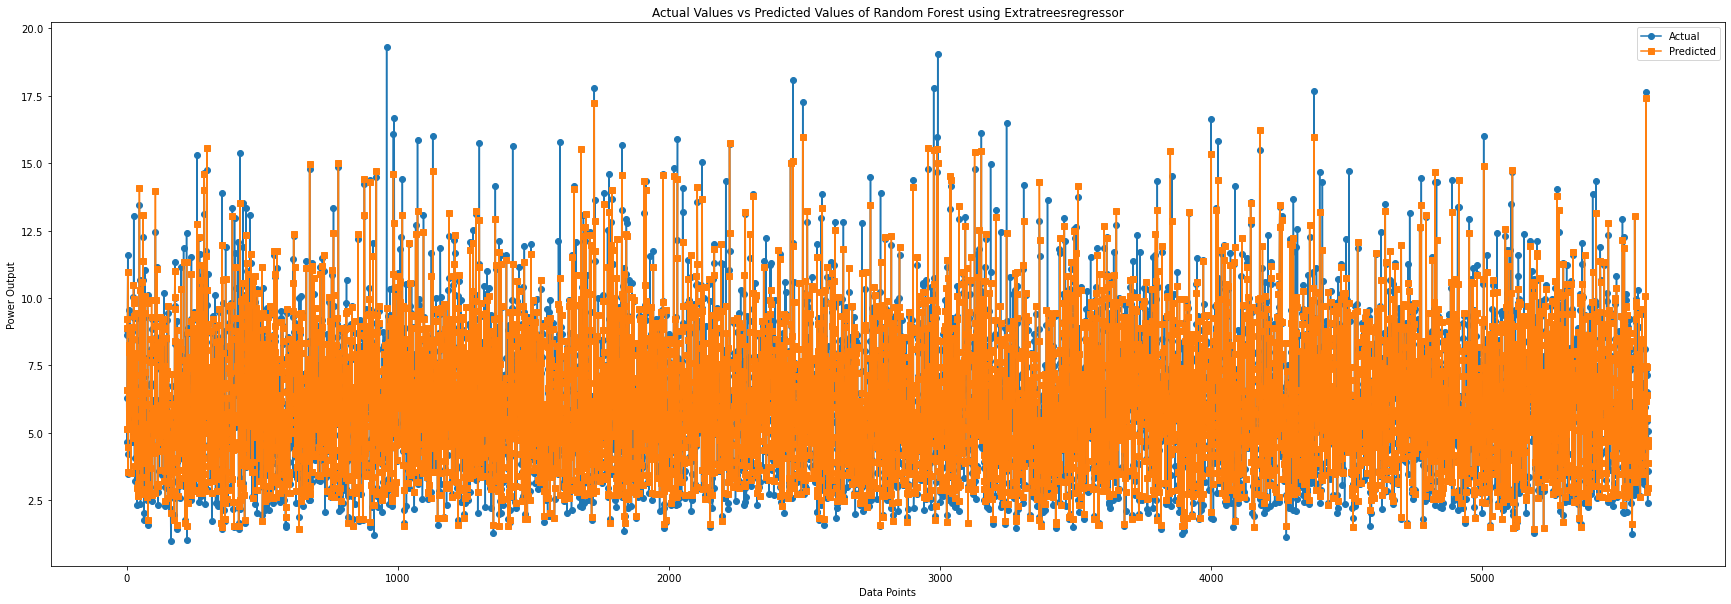

In [19]:
# Sort the actual and predicted values based on the data points
sorted_indices = range(len(y_test))
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = prediction_featureselection[sorted_indices]

# Line plot with markers for actual and predicted values
plt.rcParams['figure.figsize'] = [30, 10]
plt.plot(sorted_indices, y_test_sorted, marker='o', label='Actual')
plt.plot(sorted_indices, y_pred_sorted, marker='s', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Power Output')
plt.title('Actual Values vs Predicted Values of Random Forest using Extratreesregressor')
plt.legend()
plt.show()

### Hyperparameter tuning

In [20]:
# Hyper parameters range intialization for tuning 

parameters={
    'max_depth': [30, 50, 70],
    'min_samples_split': [20, 25, 30],
    'min_samples_leaf': [30,35,40],
    'max_features':  ["auto","log2","sqrt",None]}

In [21]:
tuning_model = GridSearchCV(tree_reg_best,param_grid=parameters,scoring='neg_mean_squared_error',n_jobs=-1,cv=5)

In [22]:
# function for calculating how much time take for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        print(thour,":",tmin,':',round(tsec,2))

In [23]:
start_time=timer(None)

tuning_model.fit(X_train,y_train)

timer(start_time)

C:\Users\Home\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


0.0 : 31.0 : 53.62


In [24]:
# best hyperparameters 
tuning_model.best_params_

{'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 20}

In [25]:
# best model score
tuning_model.best_score_

-0.8662840741708276

In [26]:
#Training RF With Best Hyperparameters
tuned_hyper_model= Pipeline([
    ('Scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(max_depth = 30, max_features = 'auto', min_samples_leaf = 30, min_samples_split = 20)) # Added to the original code
])
#DecisionTreeRegressor(max_depth = 30, max_features = 'auto', min_samples_leaf = 30, min_samples_split = 20)

In [27]:
# fitting model
tuned_hyper_model.fit(X_train,y_train)

C:\Users\Home\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Pipeline(steps=[('Scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=30, max_features='auto',
                                       min_samples_leaf=30,
                                       min_samples_split=20))])

In [28]:
# prediction 
tuned_pred = tuned_hyper_model.predict(X_test)

In [29]:
tuned_hyper_model.score(X_train,y_train)

0.9039371783558012

In [30]:
tuned_hyper_model.score(X_test,y_test)

0.88513581980587

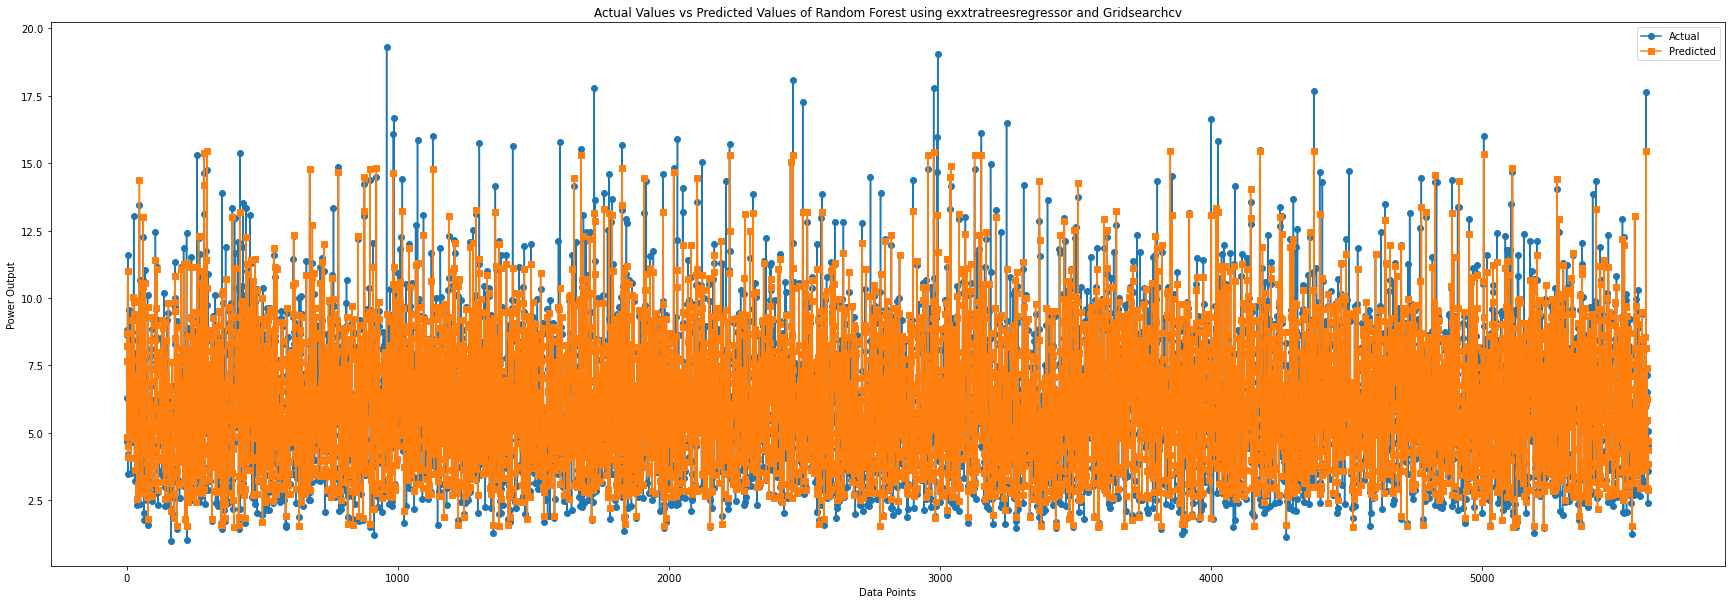

In [31]:
# Sort the actual and predicted values based on the data points
sorted_indices = range(len(y_test))
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = tuned_pred[sorted_indices]

# Line plot with markers for actual and predicted values
plt.rcParams['figure.figsize'] = [30, 10]
plt.plot(sorted_indices, y_test_sorted, marker='o', label='Actual')
plt.plot(sorted_indices, y_pred_sorted, marker='s', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Power Output')
plt.title('Actual Values vs Predicted Values of Random Forest using exxtratreesregressor and Gridsearchcv')
plt.legend()
plt.show()

In [32]:
# With hyperparameter tuned 

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,tuned_pred))
print('MSE:', metrics.mean_squared_error(y_test, tuned_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, tuned_pred)))

MAE: 0.564468514036087
MSE: 0.8641917688755117
RMSE: 0.9296191525971869


In [33]:
# without hyperparameter tuning 

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 0.5199971201592342
MSE: 0.6889532955372049
RMSE: 0.830032105124377


### save model

In [34]:
import joblib
filename = "Completed_RandomForest_model.joblib"
joblib.dump(tuned_hyper_model, filename)

['Completed_RandomForest_model.joblib']

In [35]:
loaded_model = joblib.load(filename)

### Testing the model on test data

In [36]:
model = tuned_hyper_model.predict(test_data)

In [37]:
Ywrite=pd.DataFrame(model,columns=['windmill_generated_power(kW/h)'])
Ywrite.to_csv("Prediction_RF.csv",index=False)